In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# Simulation of a Jet with Euler Equations

In [2]:
import numpy as np

In [3]:
from josie.bc import Dirichlet, Neumann, NeumannDirichlet
from josie.geom import Line
from josie.euler.eos import PerfectGas
from josie.euler.solver import EulerSolver
from josie.euler.state import Q

from josie.mesh import Mesh
from josie.mesh.cell import SimpleCell

left = Line([0, 0], [0, 1])
bottom = Line([0, 0], [0.25, 0])
right = Line([0.25, 0], [.25, 1])
top = Line([0, 1], [0.25, 1])

# EOS
eos = PerfectGas(gamma=1.4)

# Params
JET_CENTER = 0.5
JET_RADIUS = 0.05

# Inlet
U_JET = 1
V_JET = 0
RHO_JET = 1000
P_JET = 1e3

RHOe_JET = eos.rhoe(RHO_JET, P_JET)
E_JET = RHOe_JET/RHO_JET + 0.5 * (U_JET**2 + V_JET**2)
C_JET = eos.sound_velocity(RHO_JET, P_JET)
print(f"Mach: {U_JET/C_JET}")
Q_JET = Q(RHO_JET, RHO_JET*U_JET, RHO_JET*V_JET, RHO_JET*E_JET, RHOe_JET, U_JET, V_JET, P_JET, C_JET)

# Field conditions at init
U_INIT = 0
V_INIT = 0
RHO_INIT = RHO_JET/1000
P_INIT = P_JET
RHOe_INIT = eos.rhoe(RHO_INIT, P_INIT)
E_INIT = RHOe_INIT/RHO_INIT + 0.5 * (U_INIT**2 + V_INIT**2)
C_INIT = eos.sound_velocity(RHO_INIT, P_INIT)

print(f"Mach: {U_INIT/C_INIT}")

Q_INIT = Q(RHO_INIT, RHO_INIT*U_INIT, RHO_INIT*V_INIT, RHO_INIT*E_INIT, RHOe_INIT, 
           U_INIT, V_INIT, P_INIT, C_INIT)

# Neumann
dQ = np.zeros(len(Q.fields)).view(Q)

def partition_fun(centroids: np.ndarray):
    yc = centroids[..., 1].flatten()
    
    # Partition cells of the inlet
    idx = np.where((yc - JET_CENTER)**2 < JET_RADIUS**2)
    
    return idx


# Assign BC to boundaries
left.bc = NeumannDirichlet(dirichlet_value=Q_JET, neumann_value=dQ, partition_fun=partition_fun)
# left.bc = Dirichlet(Q_JET)
top.bc = Dirichlet(Q_INIT)
right.bc = Neumann(dQ)
bottom.bc = Dirichlet(Q_INIT)

mesh = Mesh(left, bottom, right, top, SimpleCell)
mesh.interpolate(25, 100)
mesh.generate()
mesh.write('mesh.xdmf')
# mesh.plot()

Mach: 0.8451542547285166
Mach: 0.0


In [4]:
# Scheme
from josie.euler.schemes import Rusanov
from josie.general.schemes.time import ExplicitEuler

class MyScheme(Rusanov, ExplicitEuler): 
    pass

scheme = MyScheme(eos)



solver = EulerSolver(mesh, scheme)


def init_fun(solver): 
    solver.values[...] = Q_INIT
    

solver.init(init_fun)

In [5]:
from josie.io.write.strategy import TimeStrategy
from josie.io.write.writer import XDMFWriter
writer = XDMFWriter("euler.xdmf", TimeStrategy(dt_save=0.01, animate=True), solver, final_time=1, CFL=0.2)
writer.solve()

<IPython.core.display.Javascript object>


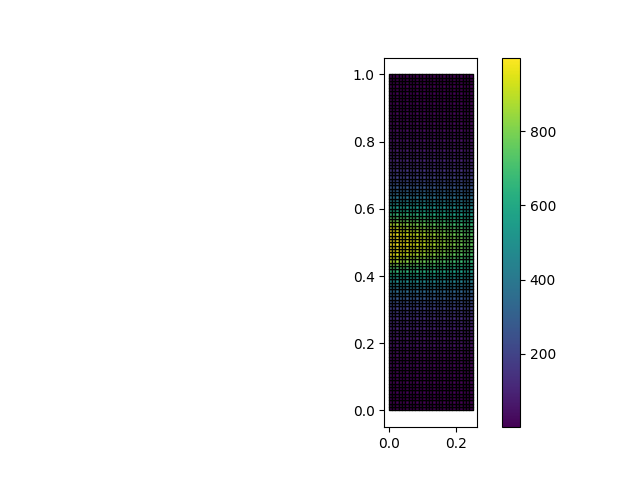

In [6]:
solver.show("rho")